In [7]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sweetviz as sv

## Connection

In [8]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='database.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [9]:
#Get the configuration file as a python dictionary
cfg = config()

In [10]:
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [11]:
try:
    #Lets get our data 
    cursor.execute('''SELECT p.acquisition_group, p.gender, p.age_group, s.title, f.unresolved::INTEGER, f.resolved::INTEGER,
                    f.fatal::INTEGER, m.retail_and_recreation::INTEGER, m.grocery_and_pharmacy::INTEGER, d.month, 
                    (CASE WHEN L.city = 'Ottawa' THEN 'Ottawa' ELSE 'Toronto' END) AS city,
                    m.parks::INTEGER
                    FROM covid19_tracking_fact_table f
                    INNER JOIN onset_date_dimension d
                    ON d.date_surrogate_key = f.onset_date_surrogate_key
                    INNER JOIN patient_dimension p 
                    ON p.patient_surrogate_key = f.patient_surrogate_key
                    INNER JOIN weather_dimension w 
                    ON w.weather_surrogate_key = f.weather_surrogate_key
                    INNER JOIN special_measures_dimension s
                    ON s.special_measures_surrogate_key = f.special_measures_surrogate_key
                    INNER JOIN mobility_dimension m 
                    ON m.mobility_surrogate_key = f.mobility_surrogate_key
                    INNER JOIN phu_location_dimension l
                    ON l.phu_location_surrogate_key = f.phu_location_surrogate_key
                    '''
                  )

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [12]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

## Summarization, Preprocessing and Feature Selection

In [37]:
#Now, 
result_df = pd.DataFrame(result_list, columns=['acquisition_group',
                                               'gender',
                                               'age_group',
                                               'special_measure',
                                               'is_unresolved',
                                               'is_resolved',
                                               'is_fatal',
                                               'retail_and_recreation_mobility',
                                               'grocery_and_pharmacy_mobility', 
                                               'month',
                                               'city',
                                               'parks_mobility'
                                              ])

Let's see how the data looks like

In [38]:
result_df.drop_duplicates()
result_df.head()

,acquisition_group,gender,age_group,special_measure,is_unresolved,is_resolved,is_fatal,retail_and_recreation_mobility,grocery_and_pharmacy_mobility,month,city,parks_mobility
0,CC,MALE,30s,Stage 2,0,1,0,-18,9,7,Toronto,79
1,CC,MALE,50s,Stage 2,0,1,0,-24,-7,7,Toronto,61
2,CC,FEMALE,40s,Stage 2,0,1,0,-22,-2,7,Toronto,82
3,OB,MALE,40s,Stage 2,0,1,0,-48,-41,7,Toronto,196
4,CS,FEMALE,50s,Stage 2,0,1,0,-24,-7,7,Toronto,61


In [39]:
my_report = sv.analyze(result_df)


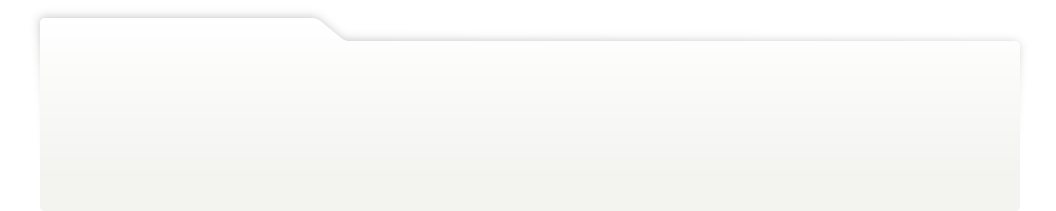
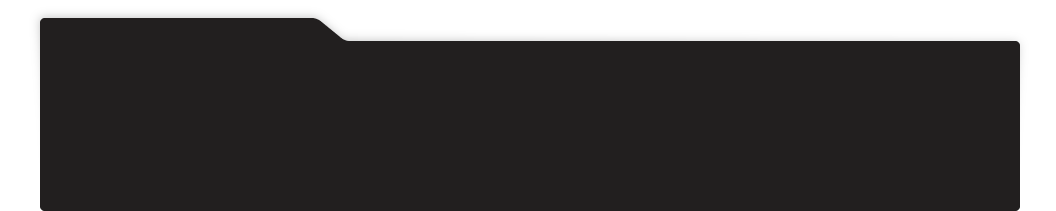
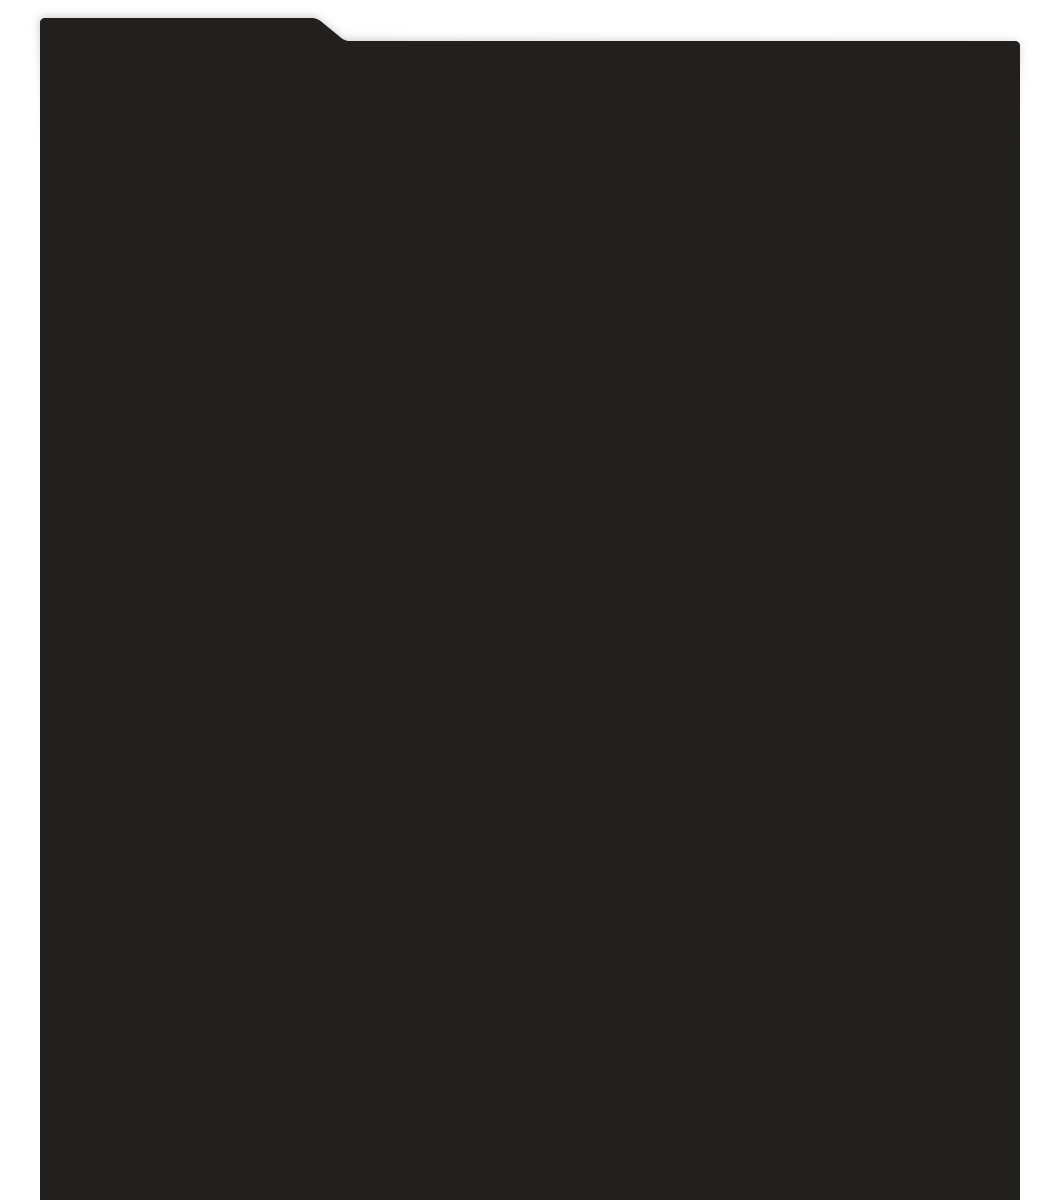
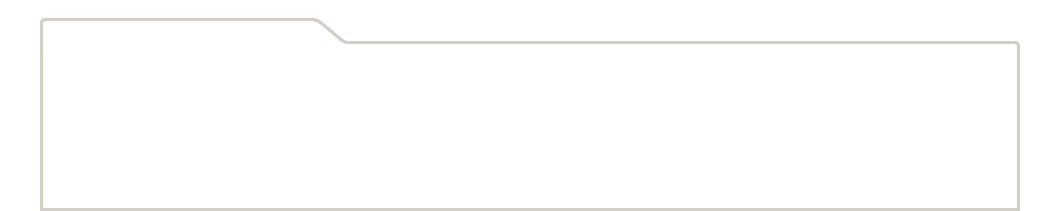
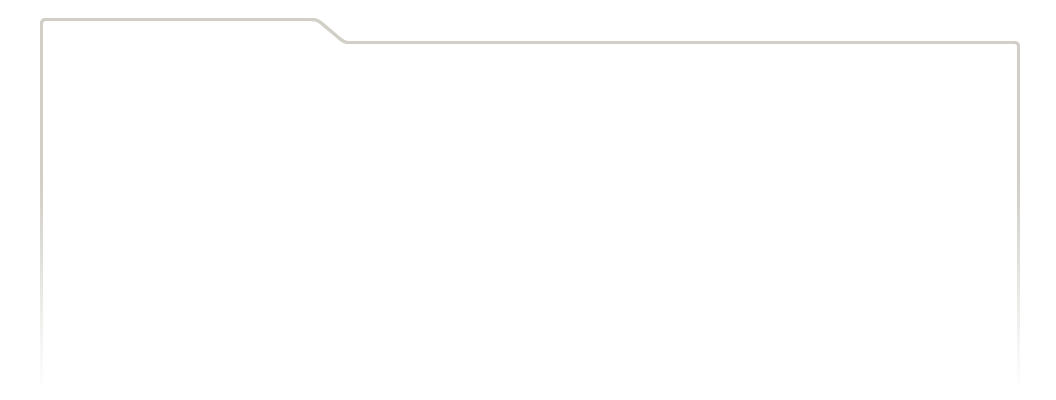
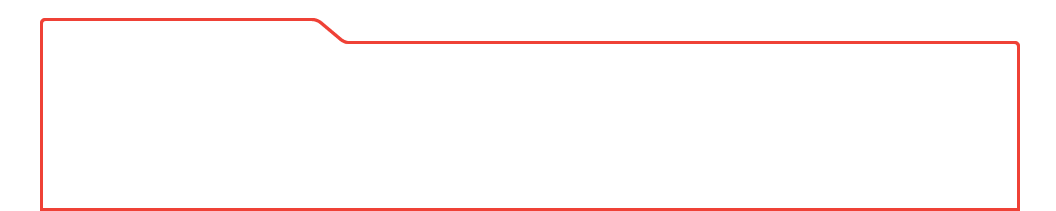
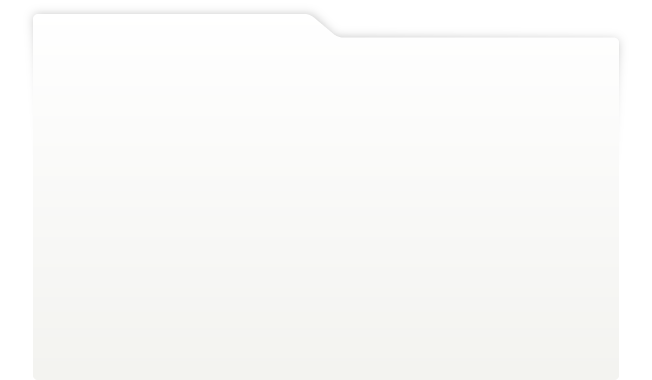
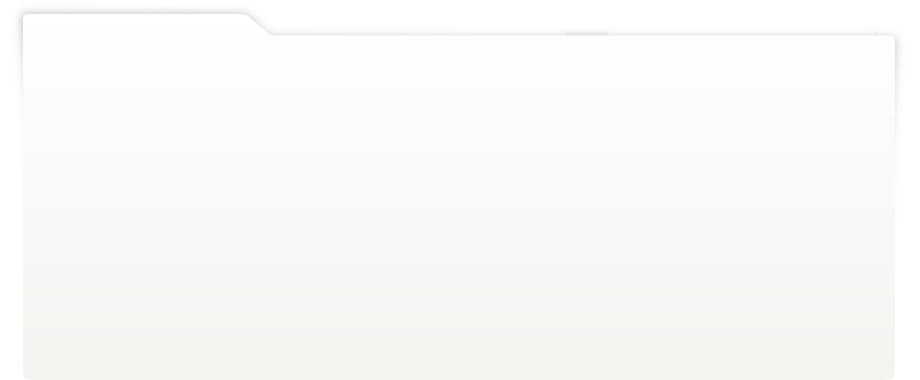
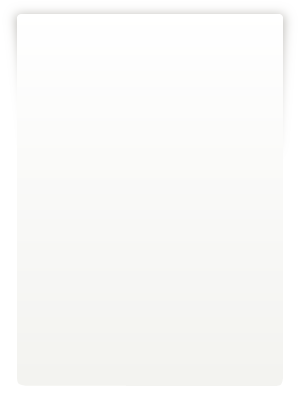
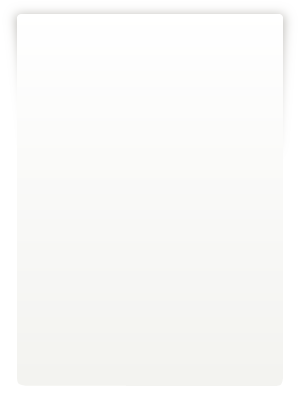
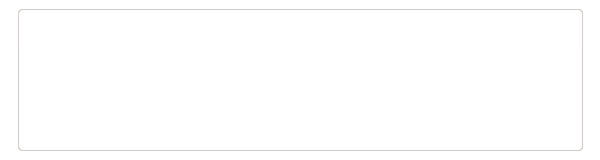
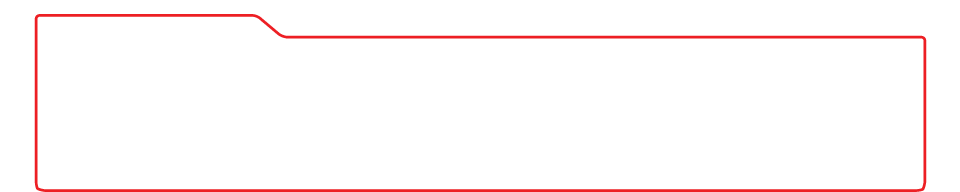
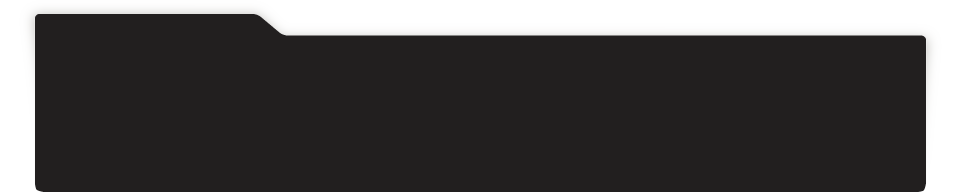
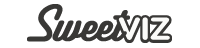
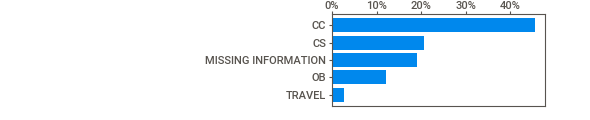
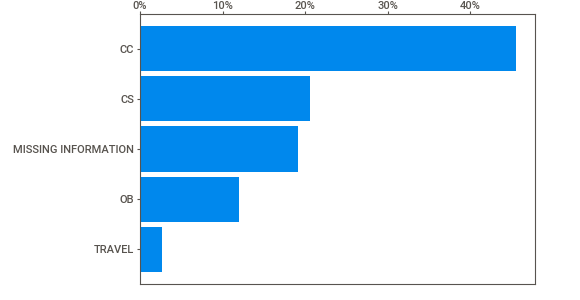
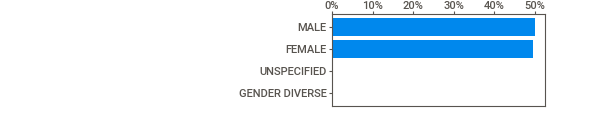
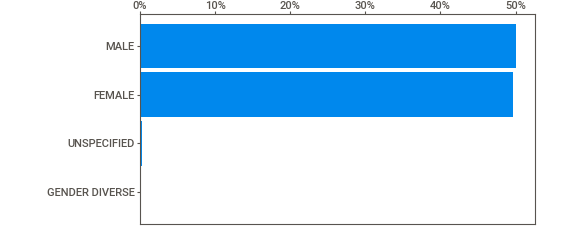
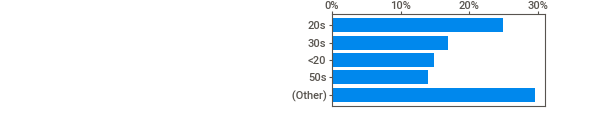
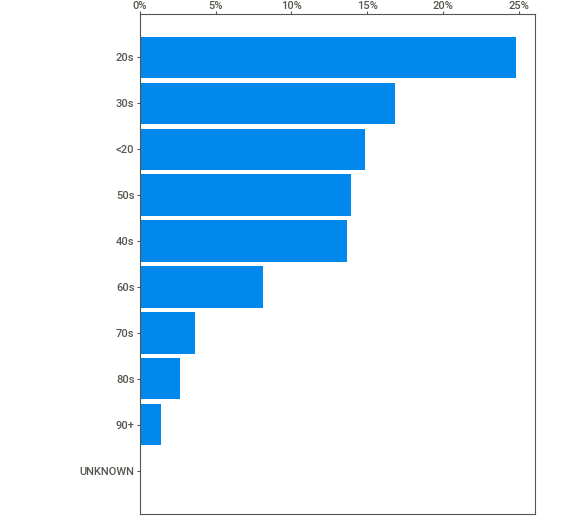
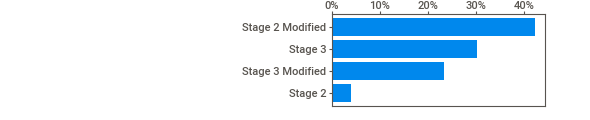
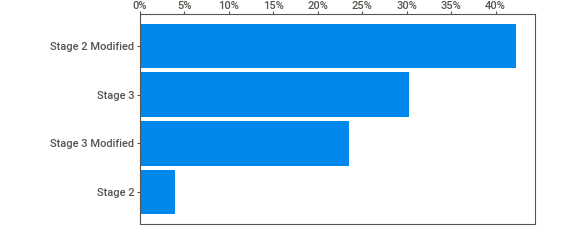
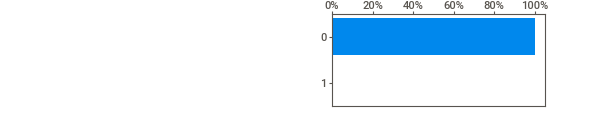
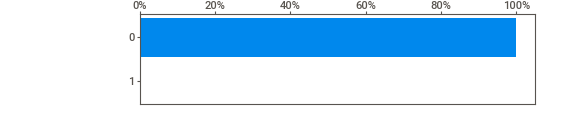
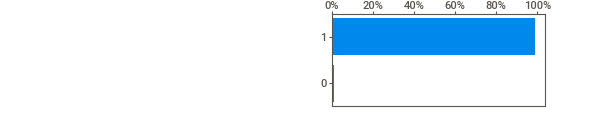
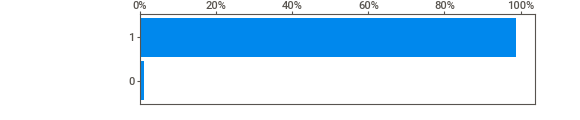
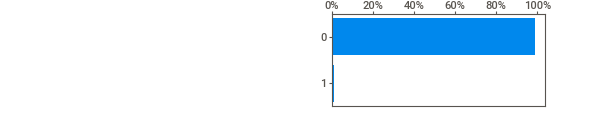
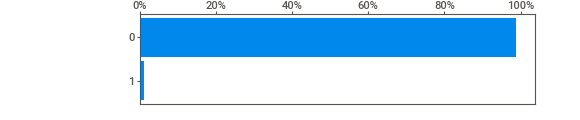
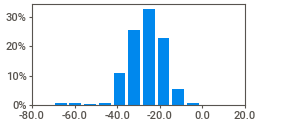
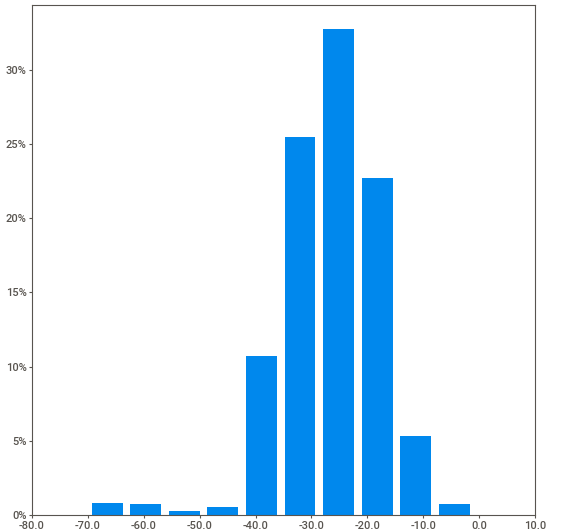
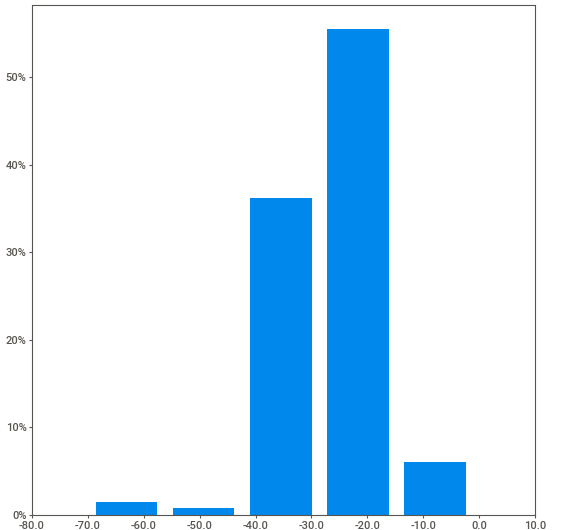
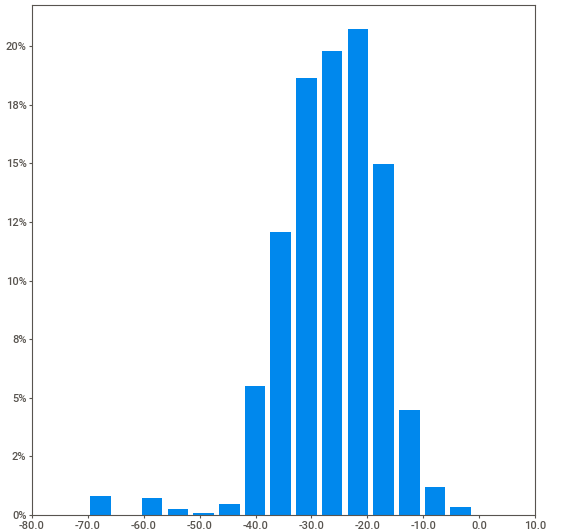
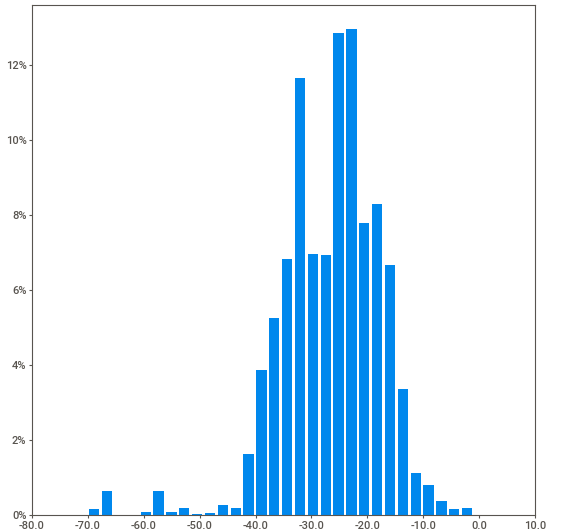
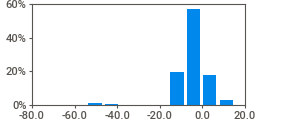
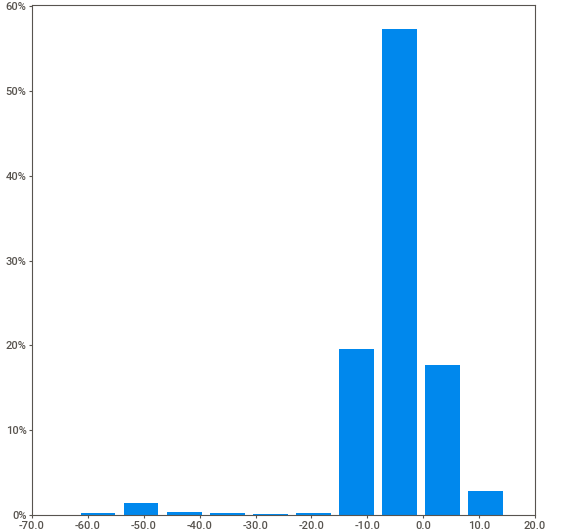
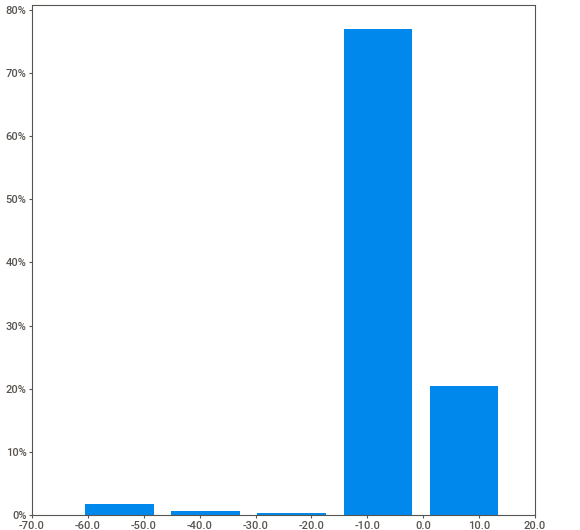
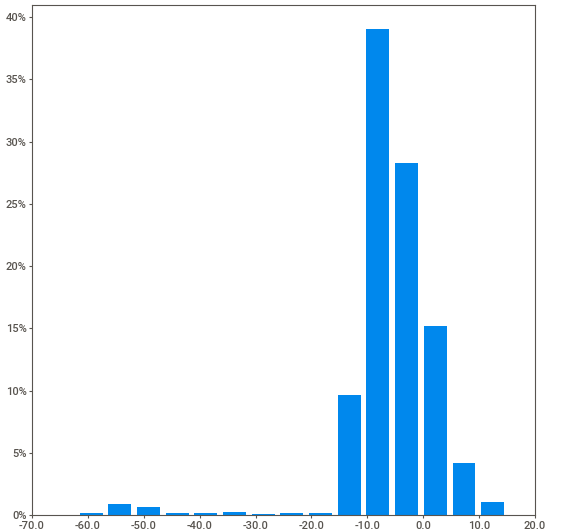
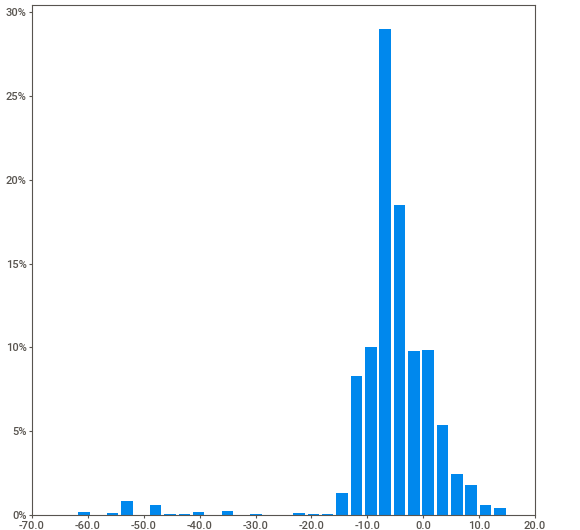
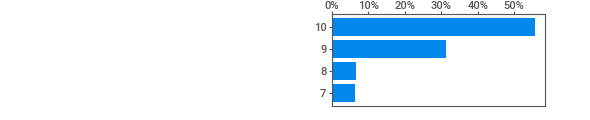
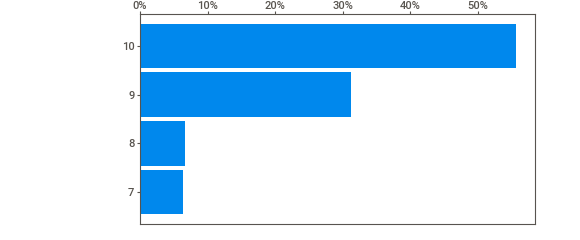
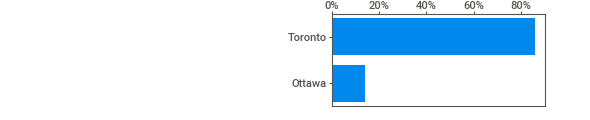
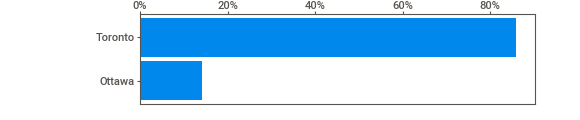
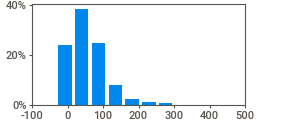
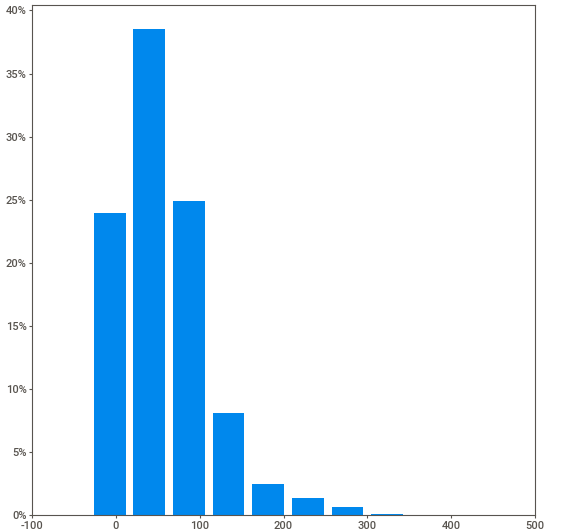
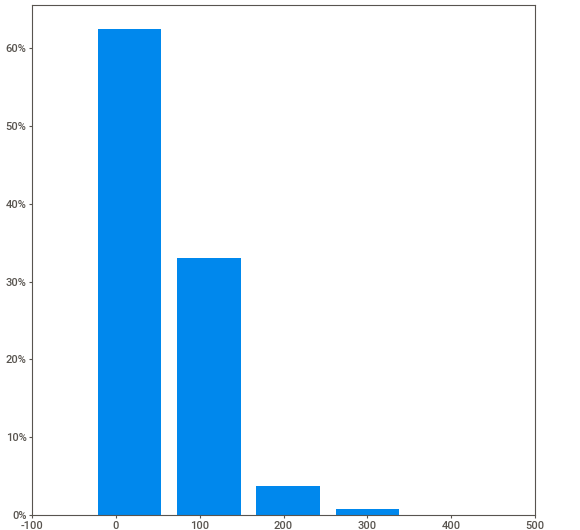
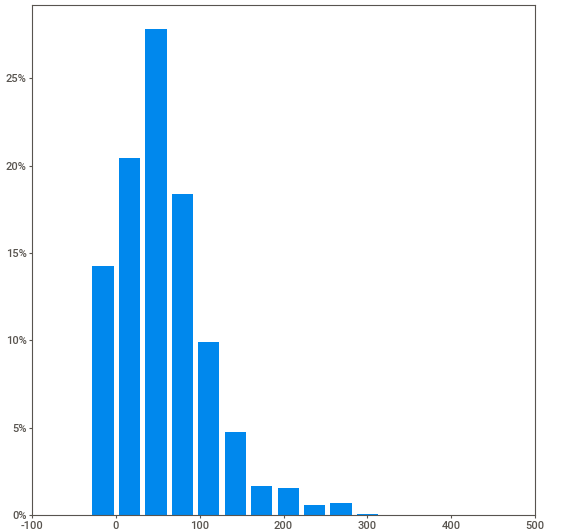
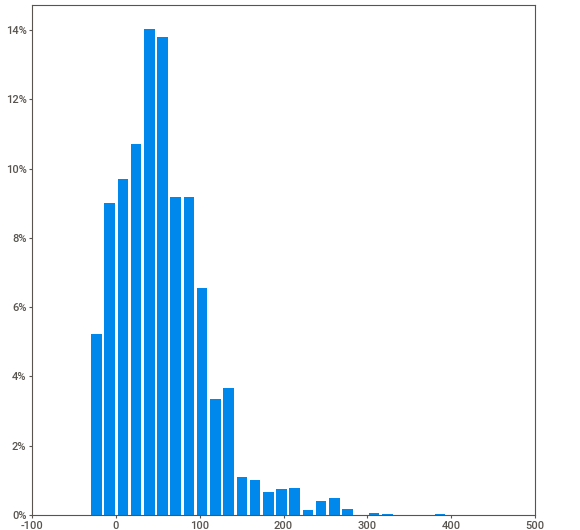
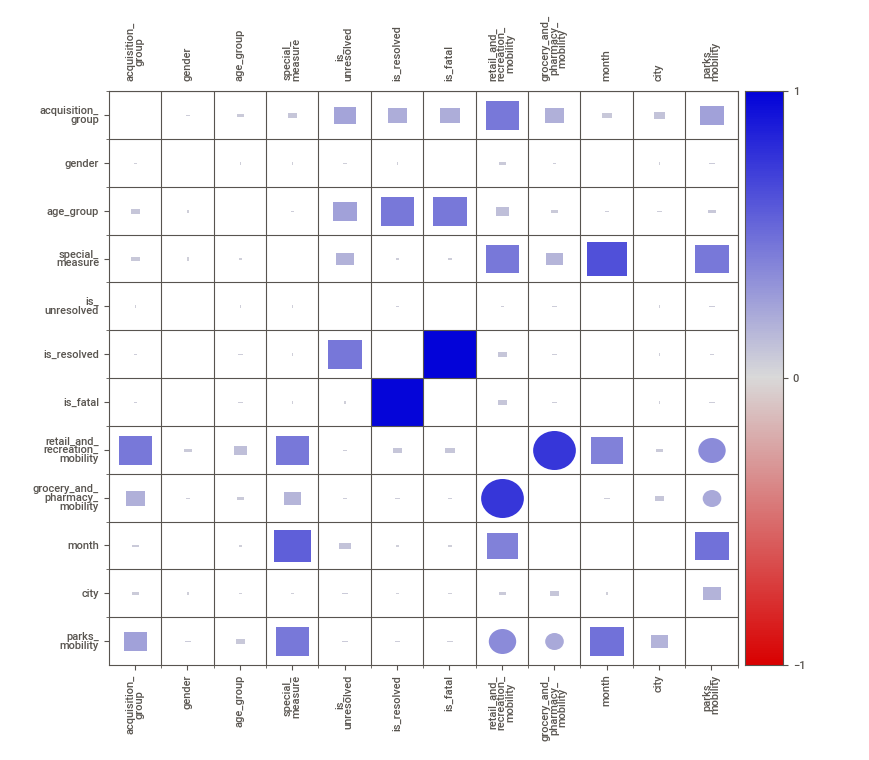
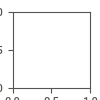

In [40]:
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

In [41]:
result_df.columns

Index(['acquisition_group', 'gender', 'age_group', 'special_measure',
       'is_unresolved', 'is_resolved', 'is_fatal',
       'retail_and_recreation_mobility', 'grocery_and_pharmacy_mobility',
       'month', 'city', 'parks_mobility'],
      dtype='object')

In [42]:
result_df.drop(result_df[result_df['acquisition_group']=='MISSING INFORMATION'].index, inplace = True)
result_df.drop(result_df[ result_df['age_group']=='UNKNOWN'].index, inplace = True)
result_df.drop(result_df[ result_df['gender'].isin(['UNSPECIFIED', 'GENDER DIVERSE'])].index, inplace = True)
result_df.drop(result_df[ result_df['is_unresolved']==1].index, inplace = True)

In [19]:
# uncomment to generate file without unresolved rows
# result_df.drop(['is_unresolved'], axis = 1, inplace = True) 

In [20]:
# result_df.is_unresolved.value_counts()

In [21]:
df = result_df.drop_duplicates()

In [22]:
# print(df.is_unresolved.value_counts())
print(df.is_resolved.value_counts())
print(df.is_fatal.value_counts())

1    12655
0      308
Name: is_resolved, dtype: int64
0    12655
1      308
Name: is_fatal, dtype: int64


In [23]:
new_result = pd.get_dummies(df, columns=['acquisition_group', 'age_group','gender','special_measure'])
#new_result = pd.get_dummies(df, columns=['age_group','gender','special_measure'])

In [24]:
new_result.columns

Index(['is_unresolved', 'is_resolved', 'is_fatal',
       'retail_and_recreation_mobility', 'grocery_and_pharmacy_mobility',
       'month', 'city', 'parks_mobility', 'acquisition_group_CC',
       'acquisition_group_CS', 'acquisition_group_OB',
       'acquisition_group_TRAVEL', 'age_group_20s', 'age_group_30s',
       'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s',
       'age_group_80s', 'age_group_90+', 'age_group_<20', 'gender_FEMALE',
       'gender_MALE', 'special_measure_Stage 2',
       'special_measure_Stage 2 Modified', 'special_measure_Stage 3',
       'special_measure_Stage 3 Modified'],
      dtype='object')

In [25]:
y = new_result.iloc[:,0:3]
y

,is_unresolved,is_resolved,is_fatal
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
36809,0,0,1
36811,0,0,1
36819,0,1,0
36824,0,0,1


In [26]:
X = new_result.drop(y, axis = 1)
X = X.drop(['month', 'city', 'parks_mobility'], axis = 1)
X

,retail_and_recreation_mobility,grocery_and_pharmacy_mobility,acquisition_group_CC,acquisition_group_CS,acquisition_group_OB,acquisition_group_TRAVEL,age_group_20s,age_group_30s,age_group_40s,age_group_50s,...,age_group_70s,age_group_80s,age_group_90+,age_group_<20,gender_FEMALE,gender_MALE,special_measure_Stage 2,special_measure_Stage 2 Modified,special_measure_Stage 3,special_measure_Stage 3 Modified
0,-18,9,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,-24,-7,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,-22,-2,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
3,-48,-41,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
4,-24,-7,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36809,-33,-6,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
36811,-36,-10,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
36819,-34,-5,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
36824,-38,-12,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, shuffle=True, stratify=y)

In [28]:
# X_train.to_csv('X_train_1d.csv', index=False)
# X_test.to_csv('X_test_1d.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

In [29]:
# y_train_1d = pd.DataFrame((y_train.iloc[:, 0:] == 1).idxmax(1), columns = ['Outcome'])
# y_test_1d = pd.DataFrame((y_test.iloc[:, 0:] == 1).idxmax(1), columns = ['Outcome'])
# y_train_1d.to_csv('y_train_1d.csv', index=False)
# y_test_1d.to_csv('y_test_1d.csv', index=False)

#### Generate csv for Binary classification of Community Spread Related

In [30]:
y_ob = new_result.iloc[:,9:10]
y_ob

,acquisition_group_CS
0,0
1,0
2,0
3,0
4,1
...,...
36809,0
36811,0
36819,0
36824,0


In [31]:
X_ob = new_result.drop(['acquisition_group_CC',
       'acquisition_group_CS', 'acquisition_group_OB',
       'acquisition_group_TRAVEL'], axis = 1)
# X_ob = X_ob.drop(X_ob.iloc[:,3:5], axis = 1)
# X_ob = X_ob.drop(X_ob.iloc[:,16:20], axis = 1)
X_ob

,is_unresolved,is_resolved,is_fatal,retail_and_recreation_mobility,grocery_and_pharmacy_mobility,month,city,parks_mobility,age_group_20s,age_group_30s,...,age_group_70s,age_group_80s,age_group_90+,age_group_<20,gender_FEMALE,gender_MALE,special_measure_Stage 2,special_measure_Stage 2 Modified,special_measure_Stage 3,special_measure_Stage 3 Modified
0,0,1,0,-18,9,7,Toronto,79,0,1,...,0,0,0,0,0,1,1,0,0,0
1,0,1,0,-24,-7,7,Toronto,61,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,1,0,-22,-2,7,Toronto,82,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,1,0,-48,-41,7,Toronto,196,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,1,0,-24,-7,7,Toronto,61,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36809,0,0,1,-33,-6,7,Toronto,109,0,0,...,0,0,1,0,0,1,1,0,0,0
36811,0,0,1,-36,-10,7,Toronto,141,0,0,...,0,0,0,0,0,1,1,0,0,0
36819,0,1,0,-34,-5,10,Toronto,48,1,0,...,0,0,0,0,1,0,0,1,0,0
36824,0,0,1,-38,-12,10,Toronto,12,0,0,...,0,0,1,0,1,0,0,1,0,0


In [32]:
X_ob = pd.get_dummies(X_ob, columns=['city'])

In [33]:
X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(X_ob, y_ob, test_size=0.2, shuffle=True, stratify=y)

In [34]:
# X_train_ob.to_csv('X_train_cs.csv', index=False)
# X_test_ob.to_csv('X_test_cs.csv', index=False)
# y_train_ob.to_csv('y_train_cs.csv', index=False)
# y_test_ob.to_csv('y_test_cs.csv', index=False)